In [1]:
!pip install diffusers 

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 32.6 MB/s eta 0:00:0000:01


In [1]:
!pip install diffusers accelerate transformers datasets 

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 9.8 MB/s eta 0:00:00:00:0100:01


In [3]:
!pip install datasets

In [2]:
import torch
from diffusers import StableDiffusionPipeline, DDPMScheduler, UNet2DConditionModel, AutoencoderKL
from transformers import CLIPTextModel, CLIPTokenizer
from datasets import load_dataset
from torch.utils.data import DataLoader
from torchvision import transforms
from PIL import Image
from torch.cuda.amp import autocast, GradScaler
import gc
from torch.utils.checkpoint import checkpoint
from torch.optim import AdamW
from tqdm.auto import tqdm

# Define the model ID and dataset name
model_id = "CompVis/stable-diffusion-v1-4"
dataset_name = "Kareem99/data77"  # replace with your dataset name

# Load the tokenizer from the correct subfolder
tokenizer = CLIPTokenizer.from_pretrained(model_id, subfolder="tokenizer")

# Load the dataset from Hugging Face
dataset = load_dataset(dataset_name)

# Define the image transformation
image_transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Reduce image size to 256x256
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# Prepare the dataset
def preprocess(example):
    prompt = example['caption']
    image = example['image']

    # Ensure the image is converted to RGB (some images might be grayscale or have alpha channels)
    if image.mode != "RGB":
        image = image.convert("RGB")

    # Apply the transformation
    image = image_transform(image)

    inputs = tokenizer(prompt, padding="max_length", truncation=True, return_tensors="pt")
    input_ids = inputs.input_ids.squeeze(0)  # Remove the batch dimension
    # Return both input_ids and pixel_values as tensors
    return {"input_ids": input_ids, "pixel_values": image}

# Apply preprocessing
dataset = dataset.map(preprocess, remove_columns=["caption"])

# Function to collate the data properly
def collate_fn(batch):
    input_ids = [item['input_ids'] for item in batch]
    pixel_values = [item['pixel_values'] for item in batch]

    # Ensure all items are tensors
    input_ids = [torch.tensor(item) if not isinstance(item, torch.Tensor) else item for item in input_ids]
    pixel_values = [torch.tensor(item) if not isinstance(item, torch.Tensor) else item for item in pixel_values]

    # Convert lists to tensors
    input_ids = torch.stack(input_ids)
    pixel_values = torch.stack(pixel_values)

    return {"input_ids": input_ids, "pixel_values": pixel_values}

# Create DataLoader with a smaller batch size
train_dataloader = DataLoader(dataset['train'], batch_size=1, shuffle=True, collate_fn=collate_fn)




The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

2024-06-10 15:31:27.230596: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-10 15:31:27.230757: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-10 15:31:27.406963: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/opt/conda/lib/python3.10/site-packages/diffusers/models/transformers/transformer_2d.py:34: FutureWarning: `Transformer2DModelOutput` is deprecated and will be removed in version 1.0.0. Importing `Transformer2DModelOutput` from `diffusers.models.transformer_2d` is deprecated and this will be removed in a future version. Please use `from diffusers.models.modeling_

tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

Generating train split:   0%|          | 0/101 [00:00<?, ? examples/s]

Map:   0%|          | 0/101 [00:00<?, ? examples/s]

In [3]:
# Load model components
text_encoder = CLIPTextModel.from_pretrained(model_id, subfolder="text_encoder")
vae = AutoencoderKL.from_pretrained(model_id, subfolder="vae")
unet = UNet2DConditionModel.from_pretrained(model_id, subfolder="unet")
scheduler = DDPMScheduler.from_pretrained(model_id, subfolder="scheduler")

# Move components to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
text_encoder.to(device)
vae.to(device)
unet.to(device)


text_encoder/config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

UNet2DConditionModel(
  (conv_in): Conv2d(4, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=320, out_features=1280, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=1280, out_features=1280, bias=True)
  )
  (down_blocks): ModuleList(
    (0): CrossAttnDownBlock2D(
      (attentions): ModuleList(
        (0-1): 2 x Transformer2DModel(
          (norm): GroupNorm(32, 320, eps=1e-06, affine=True)
          (proj_in): Conv2d(320, 320, kernel_size=(1, 1), stride=(1, 1))
          (transformer_blocks): ModuleList(
            (0): BasicTransformerBlock(
              (norm1): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
              (attn1): Attention(
                (to_q): Linear(in_features=320, out_features=320, bias=False)
                (to_k): Linear(in_features=320, out_features=320, bias=False)
                (to_v): Linear(in_features=320, out_fe

In [10]:
import torch
print(torch.cuda.get_device_name(0))

#export TORCH_CUDA_ARCH_LIST="6.0 6.1 6.2 7.0 7.5"

import torch
import os

# Print the name of the available GPU
device_name = torch.cuda.get_device_name(0)
print(f"Using GPU: {device_name}")

# Set the appropriate CUDA architecture based on the available GPU
if 'A100' in device_name:
    os.environ['TORCH_CUDA_ARCH_LIST'] = "8.0"
elif 'V100' in device_name:
    os.environ['TORCH_CUDA_ARCH_LIST'] = "7.0"
elif 'P100' in device_name:
    os.environ['TORCH_CUDA_ARCH_LIST'] = "6.0"
else:
    os.environ['TORCH_CUDA_ARCH_LIST'] = "6.0 6.1 6.2 7.0 7.5"

# Proceed with training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Training on: {device}")

# Example model and training loop
# model.to(device)
# for data, target in train_loader:
#     data, target = data.to(device), target.to(device)
#     ...


Tesla T4
Using GPU: Tesla T4
Training on: cuda


In [4]:
# Initialize the scaler
scaler = GradScaler()

# Set up optimizer
optimizer = AdamW(unet.parameters(), lr=5e-5)

# Gradient accumulation steps
accumulation_steps = 4

# Define a custom forward function to use checkpointing
def custom_forward(*inputs):
    return unet(*inputs).sample

# Training loop
num_epochs = 3
unet.train()

for epoch in range(num_epochs):
    progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}")
    optimizer.zero_grad()
    for i, batch in enumerate(progress_bar):
        # Move batch to device
        batch = {k: v.to(device) for k, v in batch.items()}

        with autocast():
            # Forward pass
            latents = vae.encode(batch["pixel_values"]).latent_dist.sample()
            latents = latents * vae.config.scaling_factor

            noise = torch.randn_like(latents)
            timesteps = torch.randint(0, scheduler.num_train_timesteps, (latents.shape[0],), device=device).long()
            noisy_latents = scheduler.add_noise(latents, noise, timesteps)

            encoder_hidden_states = text_encoder(batch["input_ids"]).last_hidden_state

            # Predict the noise residual using checkpointing
            noise_pred = checkpoint(custom_forward, noisy_latents, timesteps, encoder_hidden_states)

            loss = torch.nn.functional.mse_loss(noise_pred, noise) / accumulation_steps

        scaler.scale(loss).backward()

        if (i + 1) % accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

            # Clear variables and cache
            del latents, noise, noisy_latents, encoder_hidden_states, noise_pred
            torch.cuda.empty_cache()
            gc.collect()

        # Update progress bar
        progress_bar.set_postfix(loss=loss.item() * accumulation_steps)  # Scale loss back to original value

print("Training complete!")

/opt/conda/lib/python3.10/site-packages/torch/cuda/amp/grad_scaler.py:125: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 1:   0%|          | 0/101 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)
/opt/conda/lib/python3.10/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the dif

Epoch 2:   0%|          | 0/101 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/101 [00:00<?, ?it/s]

Training complete!


In [9]:
from diffusers import StableDiffusionPipeline
from transformers import CLIPFeatureExtractor

# Assuming vae, text_encoder, unet, scheduler, tokenizer are already defined and loaded

# Initialize the feature extractor
feature_extractor = CLIPFeatureExtractor.from_pretrained("openai/clip-vit-base-patch32")

# Set safety_checker to None if you don't need it
safety_checker = None

# Load the fine-tuned model into the pipeline
pipeline = StableDiffusionPipeline(
    vae=vae,
    text_encoder=text_encoder,
    unet=unet,
    scheduler=scheduler,
    tokenizer=tokenizer,
    safety_checker=safety_checker,
    feature_extractor=feature_extractor
).to(device)

# Define the prompt
prompt = ", small sun on right corner , points cut top and side ., mad boy kicking a soccer ball and facing left . hip is at horizon and ball mostly above horizon ., behind boy , one finger apart , surprised girl , running to left . she is same level than boy , both kids are big . boy wear sunglasses ."

# Generate the image
generated_image = pipeline(prompt).images[0]
generated_image.save("generated_image.png")


You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


  0%|          | 0/50 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


  0%|          | 0/50 [00:00<?, ?it/s]

Generated image type: <class 'PIL.Image.Image'>
Image saved as 'generated_image.png'


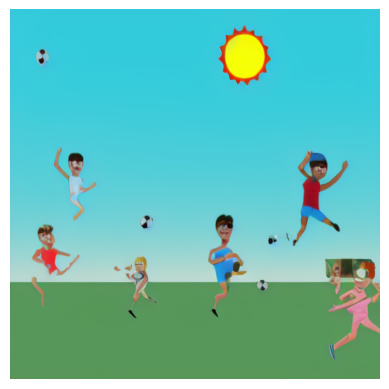

In [13]:
from diffusers import StableDiffusionPipeline
from transformers import CLIPFeatureExtractor
from PIL import Image
import matplotlib.pyplot as plt

# Assuming vae, text_encoder, unet, scheduler, tokenizer are already defined and loaded

# Initialize the feature extractor
feature_extractor = CLIPFeatureExtractor.from_pretrained("openai/clip-vit-base-patch32")

# Set safety_checker to None if you don't need it
safety_checker = None

# Load the fine-tuned model into the pipeline
pipeline = StableDiffusionPipeline(
    vae=vae,
    text_encoder=text_encoder,
    unet=unet,
    scheduler=scheduler,
    tokenizer=tokenizer,
    safety_checker=safety_checker,
    feature_extractor=feature_extractor
).to(device)

# Define the prompt
prompt = ", small sun on right corner , points cut top and side ., mad boy kicking a soccer ball and facing left . hip is at horizon and ball mostly above horizon ., behind boy , surprised girl , running to left . she is same level than boy , both kids are big . boy wear sunglasses."

# Generate the image
generated_images = pipeline(prompt).images

if generated_images:
    generated_image = generated_images[0]
    print(f"Generated image type: {type(generated_image)}")
    
    # Check if the image is a PIL Image object
    if isinstance(generated_image, Image.Image):
        generated_image.save("generated_image.png")
        print("Image saved as 'generated_image.png'")
        
        # Display the image
        plt.imshow(generated_image)
        plt.axis('off')  # Hide axes
        plt.show()
    else:
        print("Generated image is not a valid PIL Image object.")
else:
    print("No image generated.")


You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


  0%|          | 0/50 [00:00<?, ?it/s]

Generated image type: <class 'PIL.Image.Image'>
Image saved as 'generated_image.png'


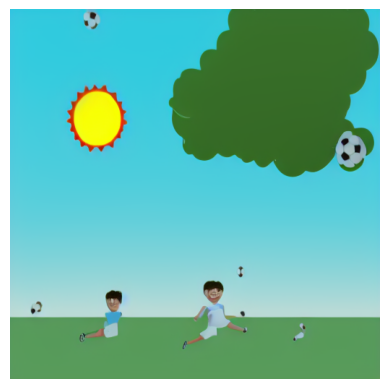

In [14]:
from diffusers import StableDiffusionPipeline
from transformers import CLIPFeatureExtractor
from PIL import Image
import matplotlib.pyplot as plt

# Assuming vae, text_encoder, unet, scheduler, tokenizer are already defined and loaded

# Initialize the feature extractor
feature_extractor = CLIPFeatureExtractor.from_pretrained("openai/clip-vit-base-patch32")

# Set safety_checker to None if you don't need it
safety_checker = None

# Load the fine-tuned model into the pipeline
pipeline = StableDiffusionPipeline(
    vae=vae,
    text_encoder=text_encoder,
    unet=unet,
    scheduler=scheduler,
    tokenizer=tokenizer,
    safety_checker=safety_checker,
    feature_extractor=feature_extractor
).to(device)

# Define the prompt
prompt = ", small sun on right corner , points cut top and side ., a boy kicking a soccer ball."

# Generate the image
generated_images = pipeline(prompt).images

if generated_images:
    generated_image = generated_images[0]
    print(f"Generated image type: {type(generated_image)}")
    
    # Check if the image is a PIL Image object
    if isinstance(generated_image, Image.Image):
        generated_image.save("generated_image.png")
        print("Image saved as 'generated_image.png'")
        
        # Display the image
        plt.imshow(generated_image)
        plt.axis('off')  # Hide axes
        plt.show()
    else:
        print("Generated image is not a valid PIL Image object.")
else:
    print("No image generated.")


In [21]:
from transformers import CLIPProcessor, CLIPModel
import torch
from PIL import Image

# Load or define the image paths
image_paths = ["/kaggle/working/generated_image.png"]

# Initialize CLIP model and processor
clip_model_id = "openai/clip-vit-base-patch32"
clip_model = CLIPModel.from_pretrained(clip_model_id).to("cpu").eval()
clip_processor = CLIPProcessor.from_pretrained(clip_model_id)

# Load and preprocess images
images = [Image.open(image_path) for image_path in image_paths]
image_inputs = clip_processor(images=images, return_tensors="pt", padding=True)

# Define the prompt
prompt = ", small sun on right corner , points cut top and side ., mad boy kicking a soccer ball and facing left . hip is at horizon and ball mostly above horizon ., behind boy , one finger apart , surprised girl , running to left . she is same level than boy , both kids are big . boy wear sunglasses ., the girl wears colorful hat ., boy is on the left and girl behind boy , bod kids are centered ."

# Truncate the prompt to fit within the maximum sequence length
max_seq_length = clip_processor.tokenizer.model_max_length
prompt = prompt[:max_seq_length]

# Preprocess text
text_inputs = clip_processor(text=prompt, return_tensors="pt", padding=True)

# Move image and text tensors to the CPU
image_inputs = {k: v.to("cpu", dtype=torch.float32) for k, v in image_inputs.items()}
text_inputs = {k: v.to("cpu") for k, v in text_inputs.items()}

# Get image and text embeddings
with torch.no_grad():
    image_embeddings = clip_model.get_image_features(**image_inputs)
    text_embeddings = clip_model.get_text_features(**text_inputs)

# Calculate cosine similarities
cosine_similarities = torch.nn.functional.cosine_similarity(image_embeddings, text_embeddings)

# Average CLIP score
clip_score = cosine_similarities.mean().item()
print(f"Average CLIP Score: {clip_score}")


Average CLIP Score: 0.2874215245246887
